In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

# Load data

In [28]:
file_path = '../data/BrentOilPrices.csv'

data = pd.read_csv(file_path)
data.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [30]:
# change dtype to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9011 non-null   datetime64[ns]
 1   Price   9011 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 140.9 KB


In [32]:
# change to series
data = data.set_index('Date')
data = data['Price']
data.head()

Date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
Name: Price, dtype: float64

In [33]:
resample = data.resample('M')
data = resample.mean()
print(data.head())
print()

Date
1987-05-31    18.580000
1987-06-30    18.860476
1987-07-31    19.856522
1987-08-31    18.979524
1987-09-30    18.313182
Freq: ME, Name: Price, dtype: float64



In [34]:
len(data)

427

# Test Harness



In [35]:
# validation and evaluation dataset
dataset, validation = data.iloc[:int(0.95 * len(data))], data.iloc[int(0.95 * len(data)):]
validation.to_csv('validation.csv')
dataset.to_csv('dataset.csv')

In [36]:
dataset.head()

Date
1987-05-31    18.580000
1987-06-30    18.860476
1987-07-31    19.856522
1987-08-31    18.979524
1987-09-30    18.313182
Freq: ME, Name: Price, dtype: float64

# Exploratory data analysis

In [37]:
dataset.describe()

count    405.000000
mean      46.408092
std       32.240345
min        9.824286
25%       18.785217
50%       32.771000
75%       66.016667
max      132.718182
Name: Price, dtype: float64

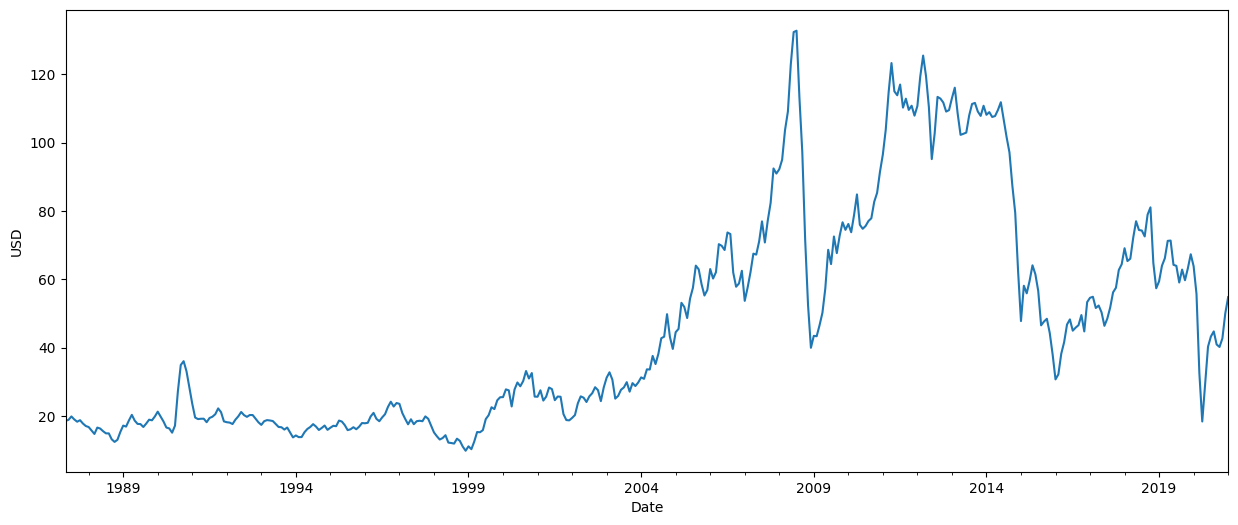

In [38]:
plt.figure(figsize=(15,6))
dataset.plot()
plt.ylabel('USD')
plt.show()

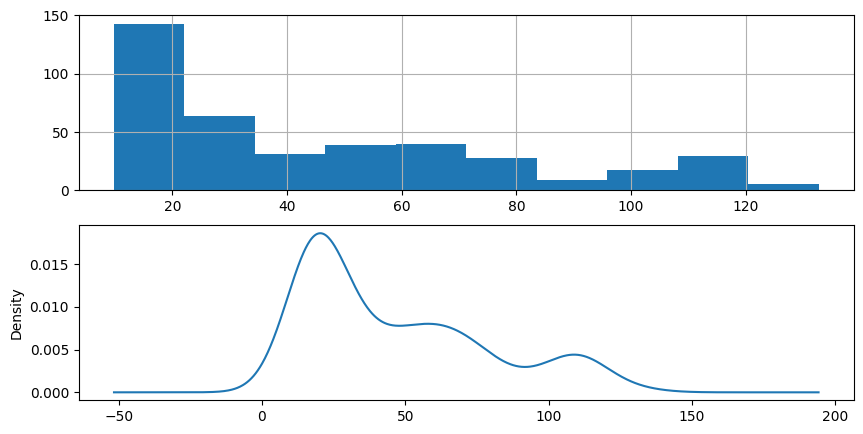

In [39]:
#density plot
plt.figure(figsize=(10,5))
plt.subplot(211)
dataset.hist()
plt.subplot(212)
dataset.plot(kind='kde')
plt.show()

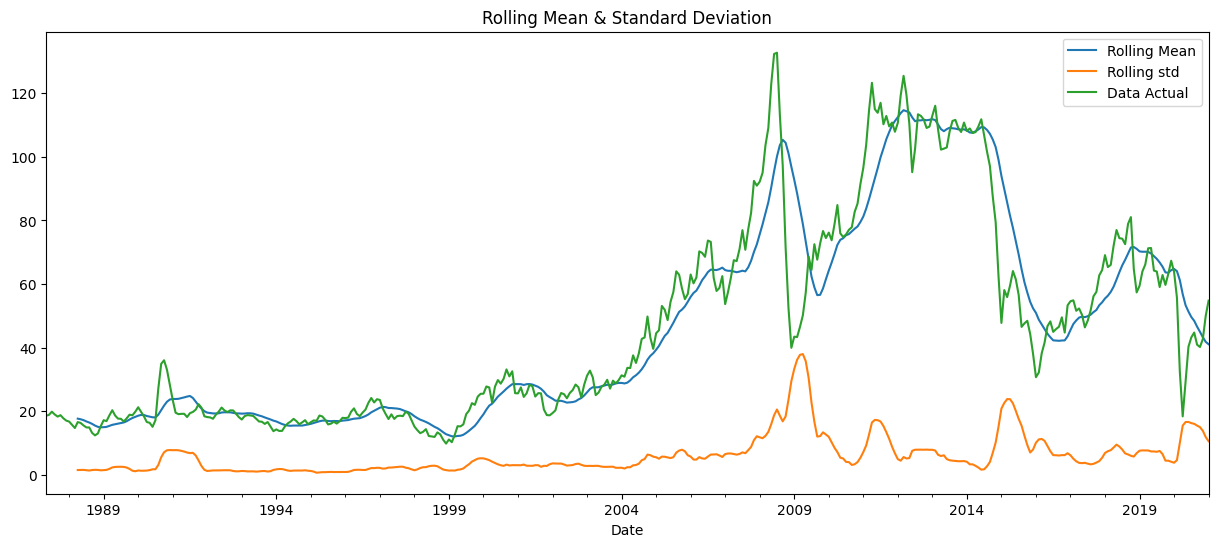

####################################################################################################
ADF Statistic: -2.278751
p-value: 0.178913
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary


In [40]:
def adfuller_test(y):
  # Plotting rolling statistics
  fig, ax = plt.subplots(figsize=(15, 6))
  y.rolling(12).mean().plot(ax=ax, label='Rolling Mean')
  y.rolling(12).std().plot(ax=ax, label='Rolling std')
  y.plot(ax=ax, label='Data Actual')
  plt.xlabel('Date')
  plt.title('Rolling Mean & Standard Deviation')
  plt.legend()
  plt.show();

  print('#'*100)
  # Aduller test
  result = adfuller(y)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
  if result[0] > result[4]['5%']:
    print('ADF > Critical Values')
    print('Failed to reject null hypothesis, time series is non-stationary')
  else:
    print('ADF < Critival Values')
    print('Reject null hypothesis, time series is stationary')

adfuller_test(dataset)

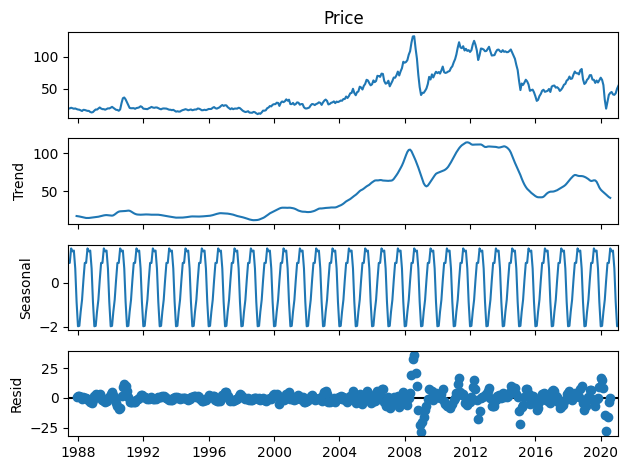

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataset, model='additive')
result.plot()
plt.show()

In [42]:
# train and test dataset
train, test = dataset.iloc[:int(0.8 * len(dataset))], dataset.iloc[int(0.8 * len(dataset)):]
print('Number of train: {}'.format(len(train)))
print('Number of test: {}'.format(len(test))) 

Number of train: 324
Number of test: 81


# Presistence foreceast model

In [43]:
# Evaluate a persistence

# Create lagged dataset
dataframe = pd.concat([dataset.shift(1), dataset], axis=1)
dataframe.columns = ['t-1', 't']
# presistence model
pred_test, pres_test = dataframe.iloc[int(0.8 * len(dataset)):, 0], dataframe.iloc[int(0.8 * len(dataset)):, 1]
# skill of presistence model
rmse = np.sqrt(mean_squared_error(pred_test, pres_test))
print('RMSE = {}'.format(rmse))

RMSE = 6.331024992289956


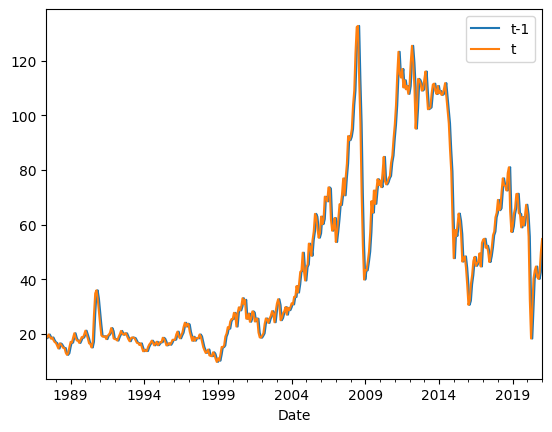

,t-1,t
Date,,
1987-05-31,NaN,18.580000
1987-06-30,18.580000,18.860476
1987-07-31,18.860476,19.856522
1987-08-31,19.856522,18.979524
1987-09-30,18.979524,18.313182


In [44]:
dataframe.plot()
plt.show()
dataframe.head()

# ARIMA Model

-0.5302353778861553


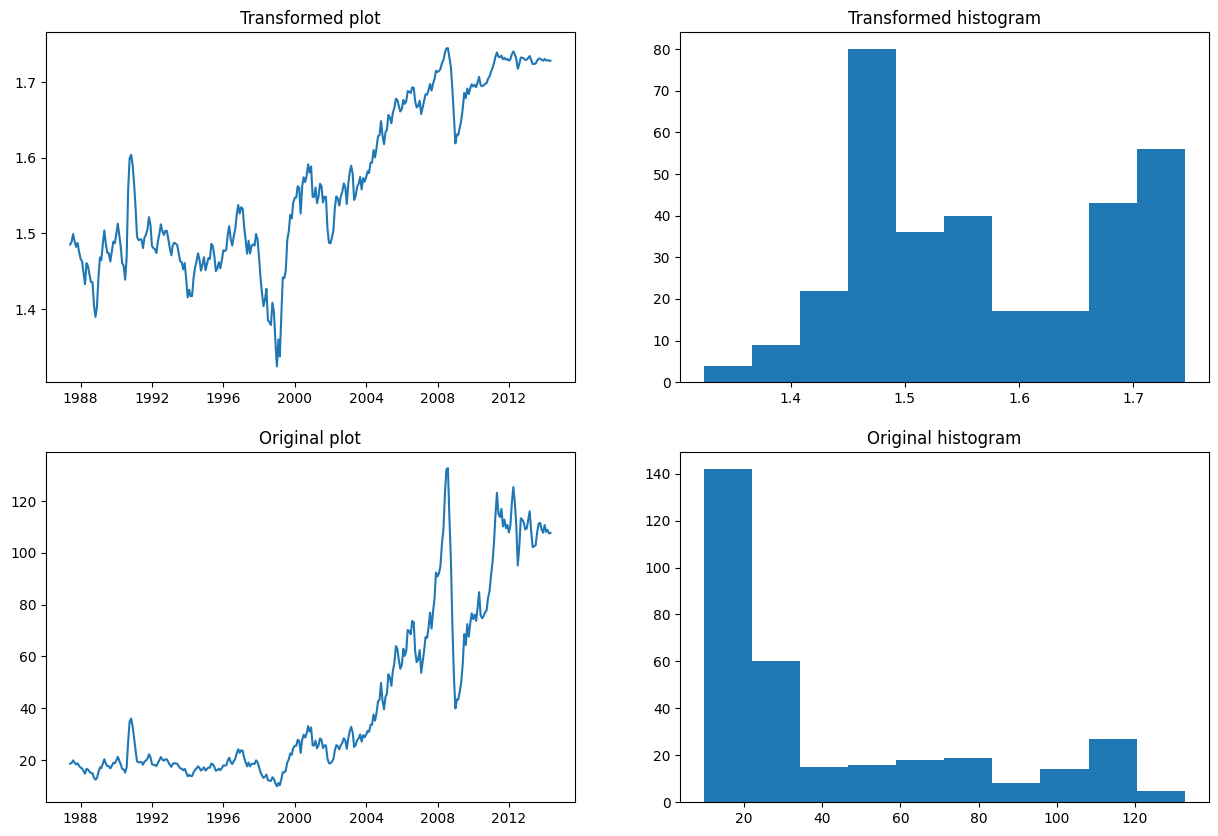

In [45]:
transform, lam = boxcox(train)
print(lam)
transform = pd.Series(transform, index=train.index)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax1.plot(transform)
ax1.title.set_text('Transformed plot')
ax2.hist(transform)
ax2.title.set_text('Transformed histogram')
ax3.plot(train)
ax3.title.set_text('Original plot')
ax4.hist(train)
ax4.title.set_text('Original histogram')
plt.show()

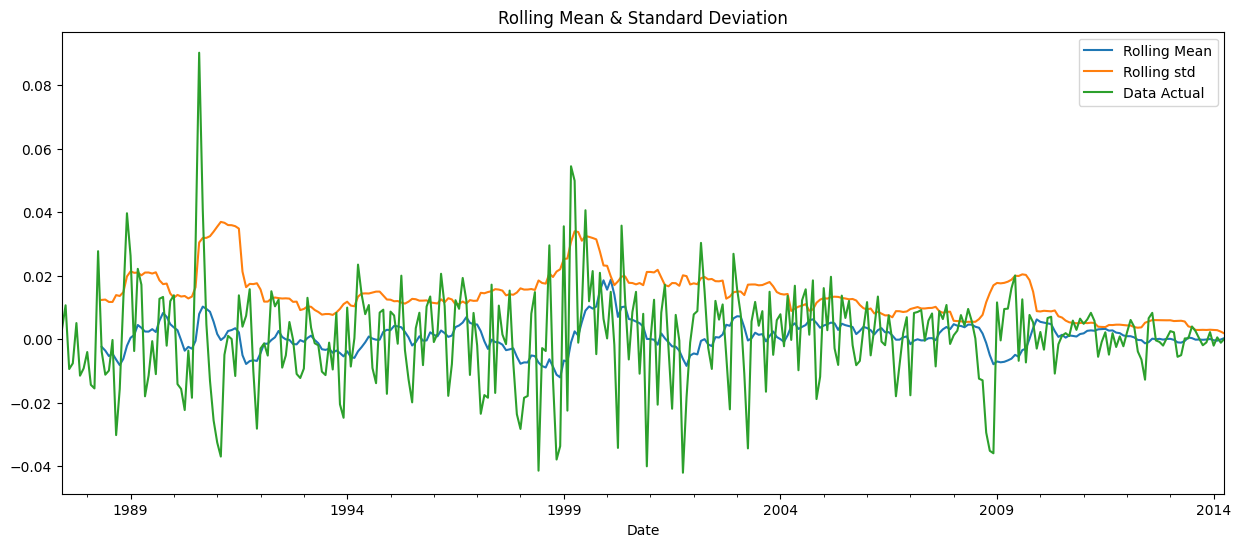

####################################################################################################
ADF Statistic: -5.848321
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
ADF < Critival Values
Reject null hypothesis, time series is stationary


In [46]:
def difference (x):
  diff = list()
  for i in range(1, len(x)):
    diff.append(x[i] - x[i - 1])
  return pd.Series(diff, index=x.index[1:])

stationary = difference(transform)
adfuller_test(stationary)

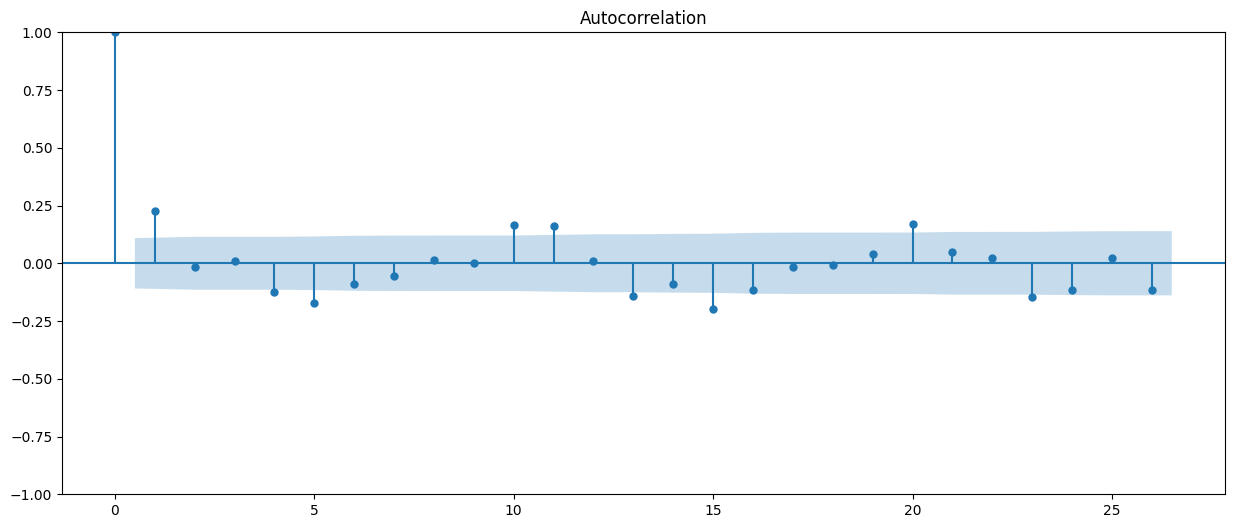

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(stationary, ax=ax);

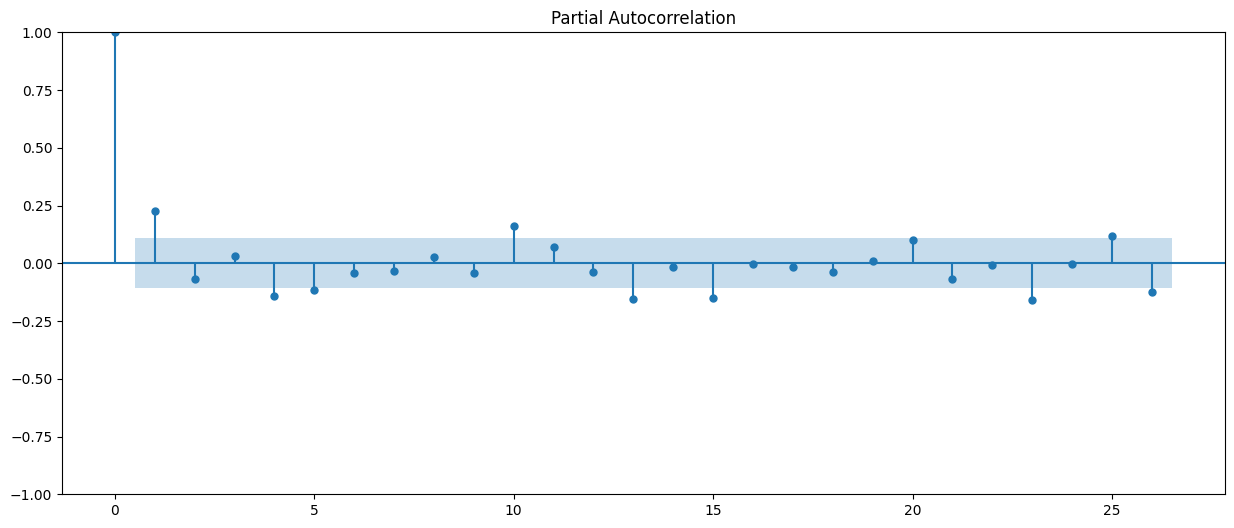

In [48]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(stationary, ax=ax);

In [49]:
# Inverse box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return np.exp(value)
  return np.exp(np.log(lam * value + 1) / lam)

# walk-forward validation
history = train.copy()
y_pred_wfv = pd.Series()
for i in range(len(test)):
  # transform data
  history_transform, lam = boxcox(history)
  history_transform = pd.Series(history_transform, index=history.index)
  if lam < -5:
    history_transform, lam = history, 1
  # predict
  model = ARIMA(history_transform, order=(2,1,2)).fit()
  next_pred = model.forecast()
  # inverse transform
  next_pred = boxcox_inverse(next_pred, lam=lam)
  y_pred_wfv = y_pred_wfv.append(next_pred)
  history = history.append(test[next_pred.index])

# dataframe result and test
dataframe = pd.DataFrame({'test': test, 'y_pred_wfv':y_pred_wfv}, index=test.index)
dataframe.head()

AttributeError: 'Series' object has no attribute 'append'

<Figure size 1080x432 with 0 Axes>

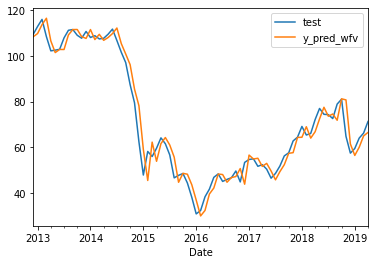

RMSE = 5.01915944594498


In [ ]:
plt.figure(figsize=(15,6))
dataframe.plot()
plt.show()
# skill of ARIMA model
rmse = np.sqrt(mean_squared_error(dataframe['test'], dataframe['y_pred_wfv']))
print('RMSE = {}'.format(rmse))

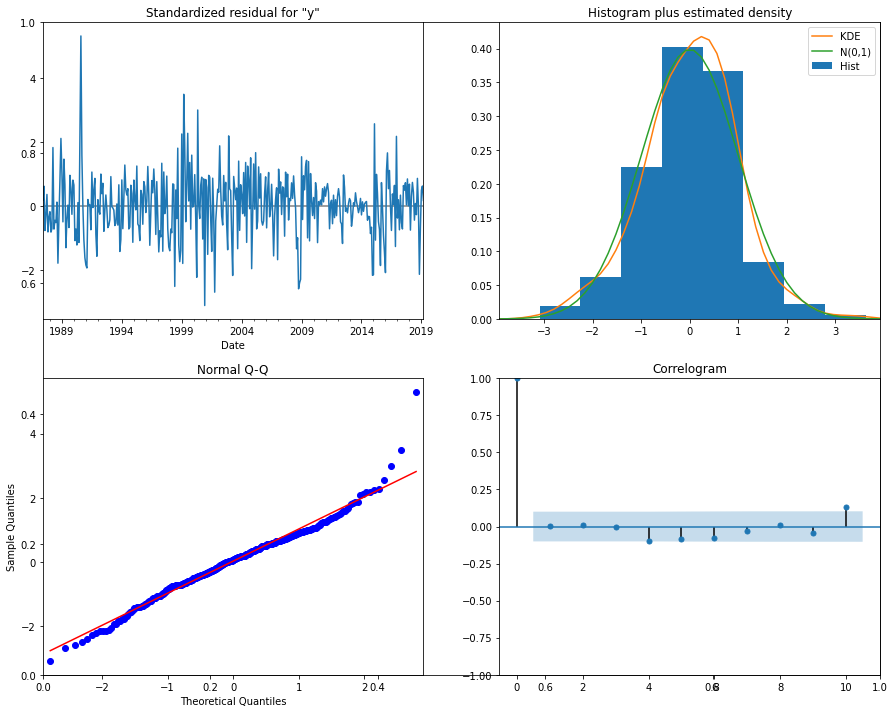

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

# Model validation

In [ ]:
# finalize model

# load data
dataset = pd.read_csv('dataset.csv', index_col=0, parse_dates=True, squeeze=True)
print(dataset.head())
print()
validation = pd.read_csv('validation.csv', index_col=0,parse_dates=True, squeeze=True)
print(validation.head())
# transform data
transform, lam = boxcox(dataset)
transform = pd.Series(transform, index=dataset.index)
# fit model
model = ARIMA(transform, order=(2,1,2)).fit()
# save model
model.save('model.pkl')
np.save('model_lambda.npy', [lam])

Date
1987-05-31    18.580000
1987-06-30    18.860476
1987-07-31    19.856522
1987-08-31    18.979524
1987-09-30    18.313182
Name: Price, dtype: float64

Date
2019-05-31    71.317727
2019-06-30    64.220500
2019-07-31    63.919130
2019-08-31    59.041818
2019-09-30    62.826667
Name: Price, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

In [ ]:
validation.index

DatetimeIndex(['2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
# make prediction
def boxcox_inverse(value, lam):
  if lam == 0:
    return np.exp(value)
  return np.exp(np.log(lam * value + 1) / lam)
# load model
model = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
# make prediction
y_pred_wfv = pd.Series()
history = dataset.copy()
# first prediction
next_pred = model.forecast()
next_pred = boxcox_inverse(next_pred, lam)
y_pred_wfv = y_pred_wfv.append(next_pred)
history = history.append(validation[next_pred.index])
for i in range(1, len(validation)):
  # Transform data
  history_transform, lam = boxcox(history)
  history_transform = pd.Series(history_transform, index=history.index)
  if lam < -5:
    history_transform, lam = history
  # Predict
  model = ARIMA(history_transform, order=(2,1,2)).fit()
  next_pred = model.forecast()
  
  # Inverse Transform
  next_pred = boxcox_inverse(next_pred, lam)
  y_pred_wfv = y_pred_wfv.append(next_pred)
  history = history.append(validation[next_pred.index])

# dataframe result and test
dataframe = pd.DataFrame({'validation': validation, 'y_pred_wfv':y_pred_wfv}, index=validation.index)
dataframe


<Figure size 1080x432 with 0 Axes>

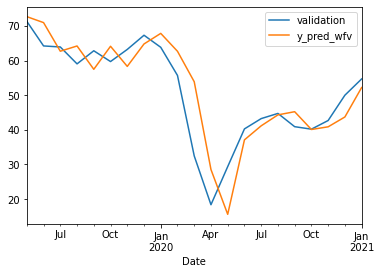

,validation,y_pred_wfv
Date,,
2019-05-31,71.317727,72.677302
2019-06-30,64.220500,70.952772
2019-07-31,63.919130,62.692779
2019-08-31,59.041818,64.207901
2019-09-30,62.826667,57.473489


In [ ]:
plt.figure(figsize=(15,6))
dataframe.plot()
plt.show()
dataframe.head()